<a href="https://colab.research.google.com/github/bhavikaradadiya/Medical-Image-Segmentation-Unet/blob/main/Medical_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation-models-pytorch==0.3.3 albumentations==1.4.0 opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=48ee34911b0124a74287c22e7ed4f36bdb4d565211909193103b67e18f12caa7
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=053105d8adf2a2414bb33636e917e3a0b8a4943281c4eaa86195647ad2499752
  Stored in directory: /root/.cache/pip/wheels/4c/01/56/40a48f75

In [10]:
import zipfile
import os

zip_path = "/content/kidney-stone.zip"      # your uploaded ZIP file
extract_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Zip extracted.")


Zip extracted.


In [12]:
dataset_path = "/content/images_txt_mask"

if os.path.exists(dataset_path):
    print("Dataset found:", dataset_path)
else:
    raise Exception("Dataset folder not found — check zip content!")


Dataset found: /content/images_txt_mask


In [13]:
print("Total files:", len(os.listdir(dataset_path)))
for f in os.listdir(dataset_path)[:10]:
    print(f)


Total files: 3065
1-3-46-670589-33-1-63735336130240422700001-5434640726191670437_png_jpg.rf.3b9b8776c656b7d3a36c32aac216acae.jpg
1-3-46-670589-33-1-63726341490934596200001-4693924108202973167_png_jpg.rf.405d4cbea27f020840fa1b92a285d101.txt
1-3-46-670589-33-1-63717199758059997000001-5740284952143614282_png_jpg.rf.22952f9efff024548e3f254204761f95.txt
1-3-46-670589-33-1-63714778964297535100001-5442181786180849541_png_jpg.rf.0f06a77662f0efcddf8941d461e213e1.jpg
1-3-46-670589-33-1-63737592870603702600001-4764044679377379557_png_jpg.rf.2cdcd7d3176838b2c64baf7faa3f016d.jpg
1-3-46-670589-33-1-63712964384112318300001-5712119739782219963_png_jpg.rf.9956c4219623cde58b1940219c81e371.jpg
1-3-46-670589-33-1-63711835265421625400001-5272784328639790072_png_jpg.rf.38479b8981757246502b6a15488d87a0.jpg
1-3-46-670589-33-1-63715204197929521500001-4736817390689786875_png_jpg.rf.8f7af2a3fd1b78d36423c429427f8a51.jpg
1-3-46-670589-33-1-63716409318753002000001-4712773722353272969_png_jpg.rf.d46c7e88bf393815a507

In [14]:
images = []
masks = []

for file in os.listdir(dataset_path):
    if file.endswith(".jpg"):
        img_path = os.path.join(dataset_path, file)
        mask_name = file.replace(".jpg", "_mask.png")
        mask_path = os.path.join(dataset_path, mask_name)

        if os.path.exists(mask_path):
            images.append(img_path)
            masks.append(mask_path)

print("Total paired samples:", len(images))


Total paired samples: 957


In [15]:
import random

combined = list(zip(images, masks))
random.shuffle(combined)

split = int(0.8 * len(combined))
train_set = combined[:split]
val_set   = combined[split:]

print("Train:", len(train_set))
print("Val:", len(val_set))


Train: 765
Val: 192


In [38]:
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn # Added import for nn.Module

class KidneyStoneDataset(Dataset):
    def __init__(self, items, transforms=None):
        self.items = items
        self.transforms = transforms

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path, mask_path = self.items[idx]

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        mask  = (mask > 127).astype(np.float32)
        mask  = np.expand_dims(mask, axis=2)

        if self.transforms:
            aug = self.transforms(image=image, mask=mask)
            image, mask = aug['image'], aug['mask']

        return image, mask

# Define CombinedLoss as a torch.nn.Module
class CombinedLoss(nn.Module):
    def __init__(self, dice_loss, focal_loss, dice_weight=0.5, focal_weight=0.5):
        super().__init__()
        self.dice_loss = dice_loss
        self.focal_loss = focal_loss
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        self.__name__ = 'CombinedLoss' # Add __name__ attribute for logging

    def forward(self, y_pred, y_true):
        return self.dice_weight * self.dice_loss(y_pred, y_true) + \
               self.focal_weight * self.focal_loss(y_pred, y_true)


In [30]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_tf = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=20),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # Added normalization
    ToTensorV2()
])

val_tf = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # Added normalization
    ToTensorV2()
])


In [32]:
from torch.utils.data import DataLoader

train_ds = KidneyStoneDataset(train_set, transforms=train_tf)
val_ds   = KidneyStoneDataset(val_set, transforms=val_tf)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)

len(train_ds), len(val_ds)


(765, 192)

In [19]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    classes=1,
    activation=None
).cuda()


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 334MB/s]


In [39]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.metrics import IoU, Fscore # Import directly

dice_loss  = smp.losses.DiceLoss(mode="binary")
focal_loss = smp.losses.FocalLoss(mode="binary")

# Use the CombinedLoss class instead of a function
loss_fn = CombinedLoss(dice_loss, focal_loss)

metrics = [
    IoU(threshold=0.5),
    Fscore(threshold=0.5)
]

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [40]:
train_epoch = smp.utils.train.TrainEpoch(
    model, loss=loss_fn, metrics=metrics,
    optimizer=optimizer, device='cuda', verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, loss=loss_fn, metrics=metrics,
    device='cuda', verbose=True
)

for epoch in range(25):
    print(f"\nEPOCH {epoch+1}/25")
    train_logs = train_epoch.run(train_loader)
    val_logs   = valid_epoch.run(val_loader)



EPOCH 1/25
valid: 100%|██████████| 24/24 [00:01<00:00, 14.55it/s, CombinedLoss - 0.5085, iou_score - 1.119, fscore - 0.2193]

EPOCH 2/25
valid: 100%|██████████| 24/24 [00:01<00:00, 14.66it/s, CombinedLoss - 0.5011, iou_score - -0.208, fscore - 0.8554]

EPOCH 3/25
valid: 100%|██████████| 24/24 [00:01<00:00, 14.81it/s, CombinedLoss - 0.4981, iou_score - -0.6047, fscore - 0.8304]

EPOCH 4/25
valid: 100%|██████████| 24/24 [00:01<00:00, 13.66it/s, CombinedLoss - 0.4942, iou_score - -0.2962, fscore - 0.7578]

EPOCH 5/25
valid: 100%|██████████| 24/24 [00:01<00:00, 14.77it/s, CombinedLoss - 0.4972, iou_score - 0.2854, fscore - 0.7702]

EPOCH 6/25
valid: 100%|██████████| 24/24 [00:01<00:00, 13.56it/s, CombinedLoss - 0.4869, iou_score - -0.2211, fscore - 0.8301]

EPOCH 7/25
valid: 100%|██████████| 24/24 [00:01<00:00, 14.93it/s, CombinedLoss - 0.4726, iou_score - -0.2563, fscore - 0.8473]

EPOCH 8/25
valid: 100%|██████████| 24/24 [00:01<00:00, 14.79it/s, CombinedLoss - 0.4376, iou_score - -0.468

In [41]:
torch.save(model.state_dict(), "/content/resunet_kidney_stone.pth")
print("Model saved!")

Model saved!


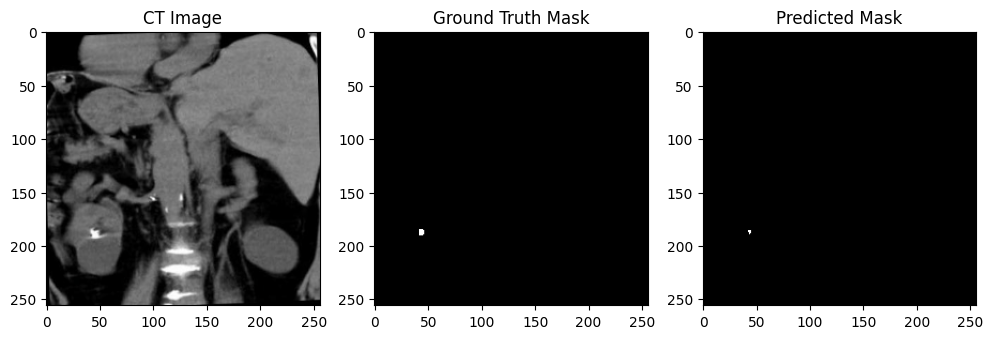

In [43]:
import matplotlib.pyplot as plt

model.eval()

img, true_mask = val_ds[3]

x = img.unsqueeze(0).cuda()

with torch.no_grad():
    pred = torch.sigmoid(model(x))[0].cpu().numpy()

pred_mask = (pred[0] > 0.5).astype(np.uint8)

# Denormalize image for display
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_display = img.permute(1, 2, 0).cpu().numpy() * std + mean
img_display = np.clip(img_display, 0, 1) # Clip to [0,1] range

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_display)
plt.title("CT Image")

plt.subplot(1,3,2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")

plt.show()